In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import missingno as msno
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

# load dataset
train_df = pd.read_csv("./Sberbank/train.csv", parse_dates=['timestamp'], index_col=False)
test_df = pd.read_csv("./Sberbank/test.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("./Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['year'] = train_df['timestamp'].dt.year


# Outliers/Transformations
y_train = pd.DataFrame(train_df['price_doc'])
X_train = pd.DataFrame(train_df.loc[:, train_df.columns != 'price_doc'])
# X_test = test.values

In [172]:
test_df['month'] = test_df['timestamp'].dt.month
test_df['day'] = test_df['timestamp'].dt.day
test_df['year'] = test_df['timestamp'].dt.year

frames = [train_df, test_df]

df = pd.concat(frames)

In [180]:
from sklearn import model_selection

X_train_all, X_test_all, y_train_all, y_test_all = model_selection.train_test_split(
                                                                df.loc[:, df.columns != 'price_doc'], 
                                                                df['price_doc'], test_size=1.0/5, random_state=0)

In [2]:
# rescale data
def rescale(feature):
    return feature.values.reshape(-1,1)

# standardize data
from sklearn.preprocessing import StandardScaler

def standardize(feature):
    scaler = StandardScaler().fit(feature)
    return scaler.transform(feature)

# normalize data
from sklearn.preprocessing import Normalizer

def normalize(feature):
    scaler = Normalizer().fit(feature)
    return scaler.transform(feature)

In [3]:
def reshape_feature(feature):
    preprocess_df = rescale(feature)
    preprocess_df = standardize(feature)
    preprocess_df = normalize(feature)
    return preprocess_df[0]

In [4]:
date_range = [train_df['timestamp'].min(),train_df['timestamp'].max()]
print date_range

[Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00')]


In [32]:

macro_df['timestamp'].max()
macro_df['timestamp'].min()

Timestamp('2010-01-01 00:00:00')

In [30]:
date_range = [test_df['timestamp'].min(),test_df['timestamp'].max()]
date_range

[Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00')]

In [5]:
time_price = train_df.loc[:, ['timestamp','price_doc']]
time_price = time_price.set_index('timestamp')

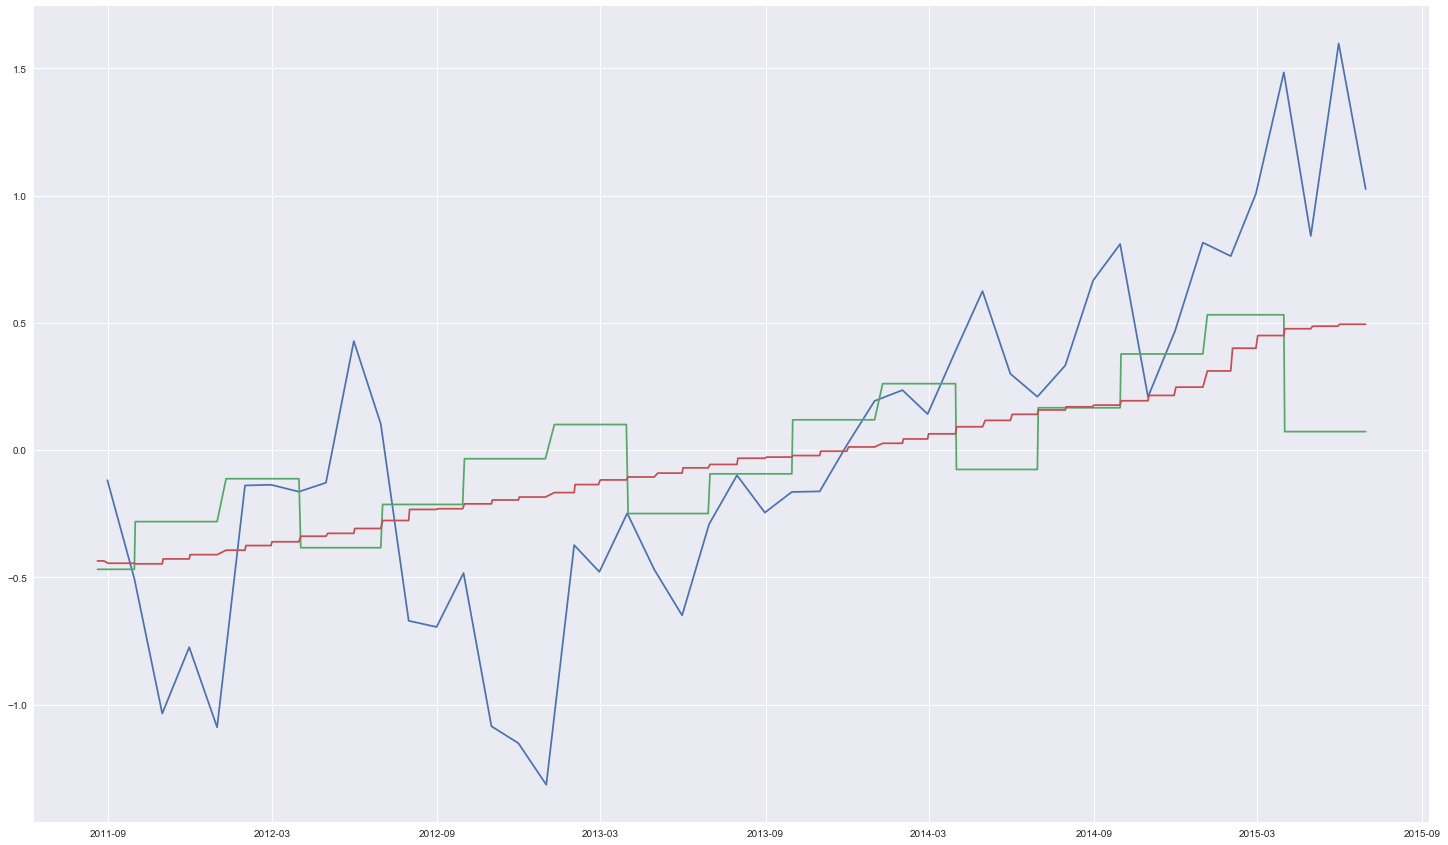

In [6]:
price_per_day = train_df.loc[:, ['timestamp','price_doc']].groupby('timestamp').mean()
price_per_day = (price_per_day - price_per_day.mean()) / (price_per_day.max() - price_per_day.min())
gdp_day = train_df.loc[:, ['timestamp','gdp_quart']].groupby('timestamp').mean()
gdp_day = (gdp_day - gdp_day.mean()) / (gdp_day.max() - gdp_day.min())
cpi = train_df.loc[:, ['timestamp','cpi']].groupby('timestamp').mean()
cpi = (cpi - cpi.mean()) / (cpi.max() - cpi.min())




plt.figure(figsize=(25, 15))
plt.plot(price_per_day.resample('M').sum())
plt.plot(gdp_day)
plt.plot(np.log1p(cpi))
plt.show()


In [7]:
by_month = train_df.loc[:,['month','year','price_doc']]
by_month = by_month.reset_index()

price_per_month = train_df.groupby(['month','year']).mean()['price_doc']


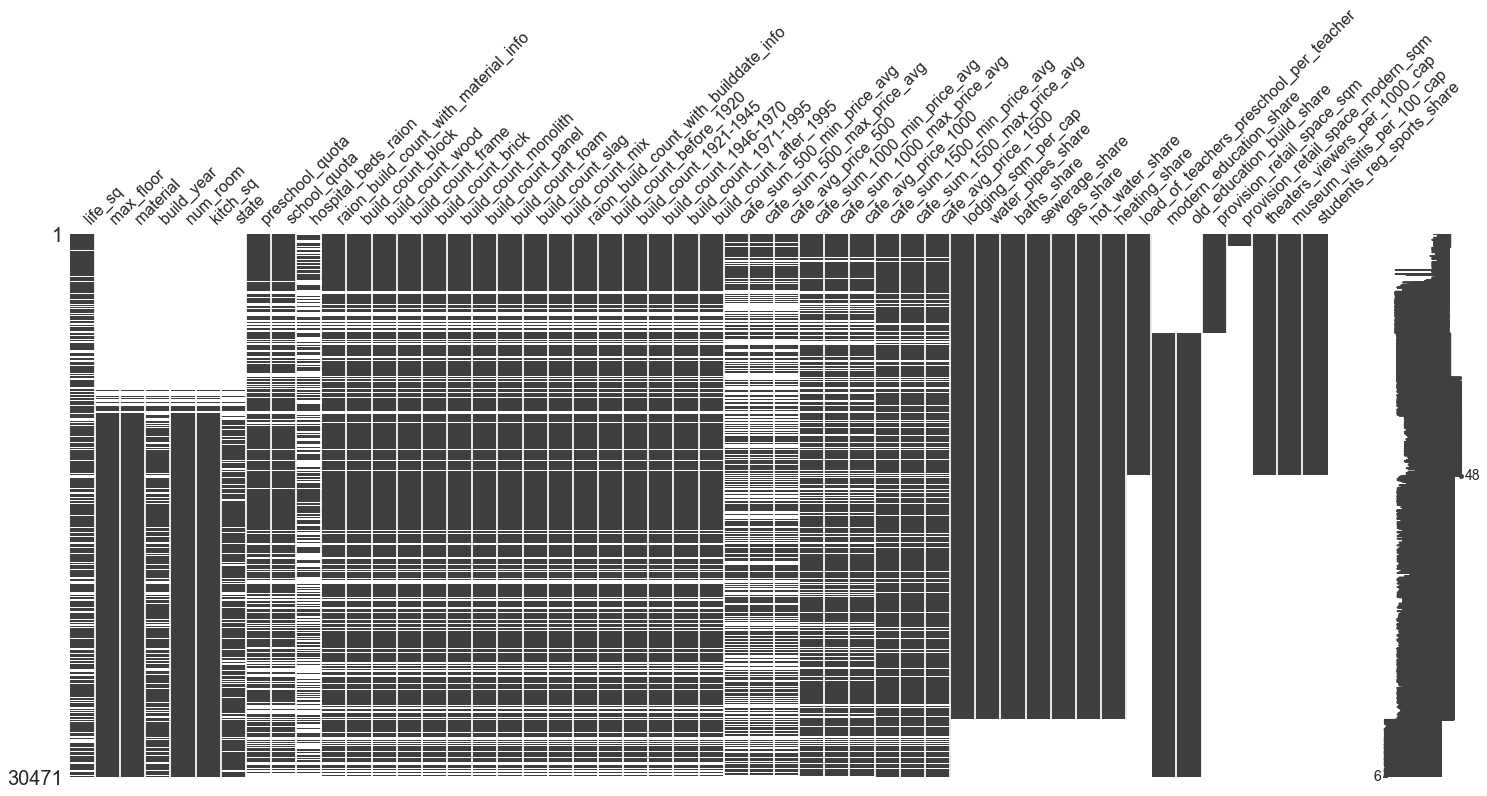

In [8]:
filtered_data = msno.nullity_filter(train_df, filter='bottom', n=50, p=0.999) # or filter='top'
msno.matrix(filtered_data)

### Looking at features in macro.csv

In [9]:
important_macro_features = ['gdp_quart', 'cpi', 'ppi', 'usdrub', 'eurrub', 
                            'gdp_annual', 'rts', 'micex', 'micex_cbi_tr', 'deposits_rate', 
                            'mortgage_rate', 'income_per_cap', 'salary', 'labor_force', 
                            'unemployment', 'employment']

macro_feature_df = train_df.loc[:, important_macro_features]

In [78]:
df_important = df.loc[:, ['timestamp', 'full_sq',
                          'life_sq', 'floor', 'max_floor', 'material',
                          'build_year', 'num_room',
                          'kitch_sq', 'state',
                          'product_type', 'sub_area',
                          'indust_part', 'school_education_centers_raion',
                          'sport_objects_raion', 'culture_objects_top_25_raion',
                          'oil_chemistry_raion', 'metro_min_avto',
                          'green_zone_km', 'industrial_km',
                          'kremlin_km', 'radiation_km',
                          'ts_km', 'fitness_km',
                          'stadium_km', 'additional_education_km',
                          'cafe_count_1500_price_500', 'cafe_count_1500_price_high',
                          'cafe_count_2000_price_2500', 'trc_sqm_5000',
                          'cafe_count_5000', 'cafe_count_5000_price_high',
                          'gdp_quart', 'cpi',
                          'ppi', 'usdrub',
                          'eurrub', 'gdp_annual',
                          'rts', 'micex',
                          'micex_cbi_tr', 'deposits_rate',
                          'mortgage_rate', 'income_per_cap',
                          'salary', 'labor_force',
                          'unemployment', 'employment', 'price_doc']]



In [61]:
y_train = pd.DataFrame(df_important['price_doc']).values
X_train = pd.DataFrame(df_important.loc[:, df_important.columns != 'price_doc']).values

In [142]:
missing_impt_features = ['full_sq', 'life_sq', 'product_type', 'floor', 'max_floor', 
'material', 'build_year','num_room', 'kitch_sq', 'state', 'price_doc']

missing_df = df.loc[:, missing_impt_features]

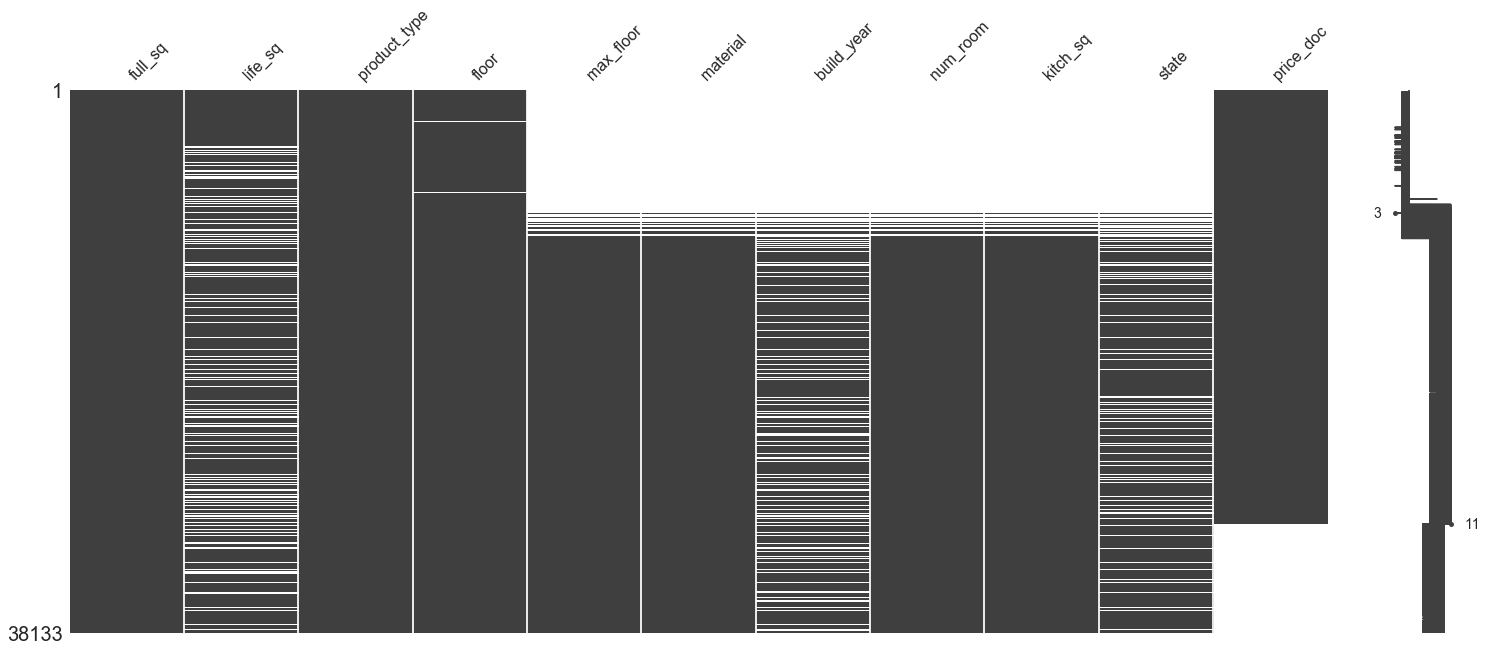

In [143]:
filtered_data = msno.nullity_filter(missing_df, filter='bottom', n=12, p=0.5) # or filter='top'
msno.matrix(missing_df)

In [147]:
df[df['product_type'].isnull()]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
4662,3112,1512,1600,3831,1858,1973,1706,844,862,55710,...,2.032918,13331,6661,6670,5.363422,2016,3459,1677,1782,25.155085
4681,11903,5975,5928,14994,7572,7422,6120,3024,3096,17070,...,10.300190,56908,29689,27219,2.942168,2016,13523,6799,6724,12.416657
4753,1207,584,623,1542,742,801,656,316,340,3134,...,6.883806,6127,2890,3237,5.001440,2016,1370,661,709,21.307436
4784,506,245,261,646,311,336,275,133,143,3796,...,18.733740,2566,1211,1356,12.264390,2016,574,277,297,29.375351
4791,17622,8373,9249,22087,10546,11541,9254,4398,4856,32847,...,20.094930,97920,44878,53042,2.262113,2016,20003,9542,10461,16.335754
4800,506,245,261,646,311,336,275,133,143,3796,...,17.328100,2566,1211,1356,10.953069,2016,574,277,297,27.877401
5047,11003,5225,5778,13507,6419,7088,6354,2982,3372,27107,...,17.566820,81271,38523,42748,7.675466,2016,12244,5826,6418,23.694245
5099,13592,6817,6775,17354,8619,8735,7116,3527,3589,19098,...,14.817760,65613,31784,33829,2.077985,2016,15500,7734,7766,7.104167
5111,8301,4082,4219,10896,5324,5572,4215,2054,2161,15835,...,9.760343,51445,26442,25003,3.607816,2016,9414,4599,4815,11.341713
5193,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,4.129139,63388,31575,31813,2.391537,2016,13028,6193,6835,10.757745


In [156]:
(df.loc[df['product_type'].notnull() & df['price_doc'].notnull()].corr()).to_csv('./correlation_table.csv')



In [115]:
lifesq_floor = df.loc[df['life_sq'].notnull() & df['price_doc'].notnull(), ['life_sq','price_doc']]

lifesq_floor[['life_sq','price_doc']].corr()


,life_sq,price_doc
life_sq,1.000000,0.165606
price_doc,0.165606,1.000000


In [116]:
fullsq_floor = df.loc[df['full_sq'].notnull() & df['price_doc'].notnull(), ['full_sq','price_doc']]

fullsq_floor[['full_sq','price_doc']].corr()

,full_sq,price_doc
full_sq,1.00000,0.34184
price_doc,0.34184,1.00000


In [121]:
np.sum(df.loc[df['full_sq'].isnull(), 'life_sq'].isnull())

0

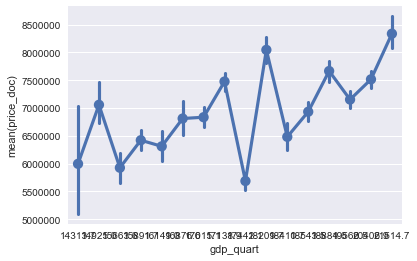

In [11]:
sns.pointplot(train_df['gdp_quart'],train_df['price_doc'])

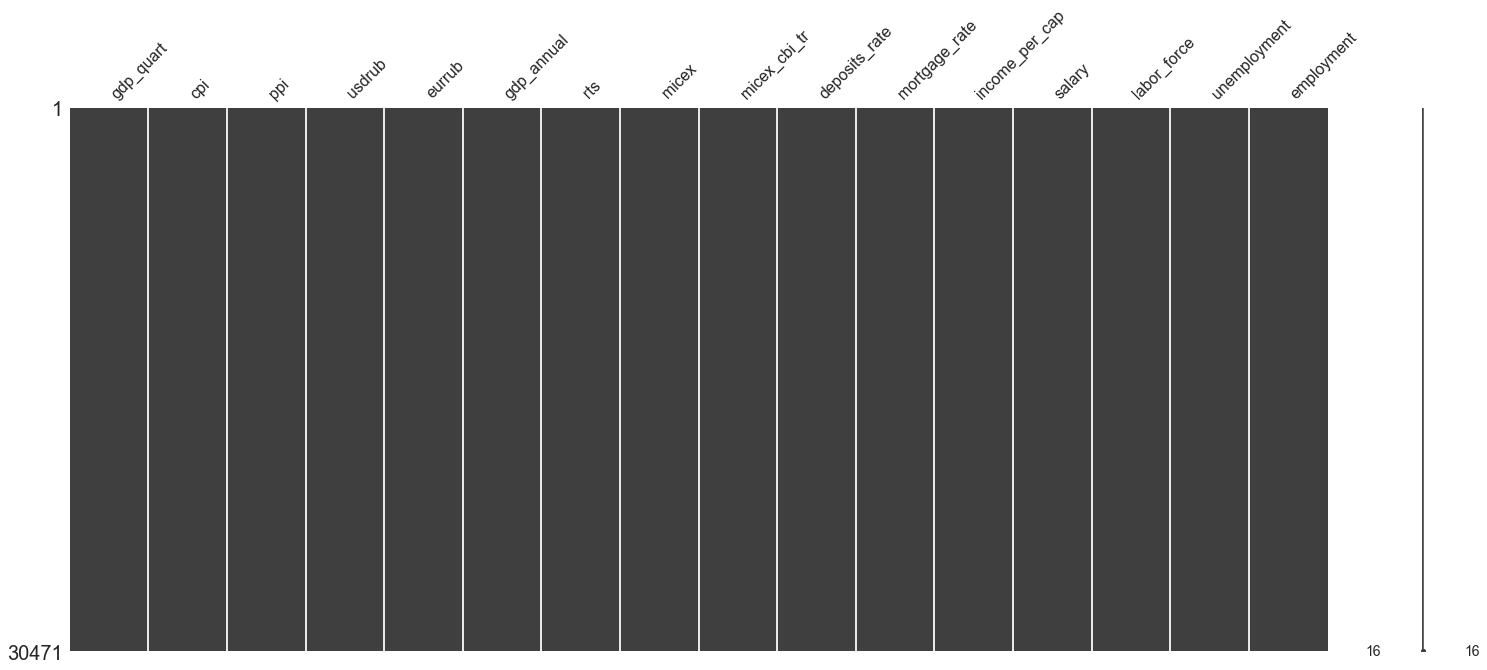

In [12]:
msno.matrix(macro_feature_df)

no missing features!

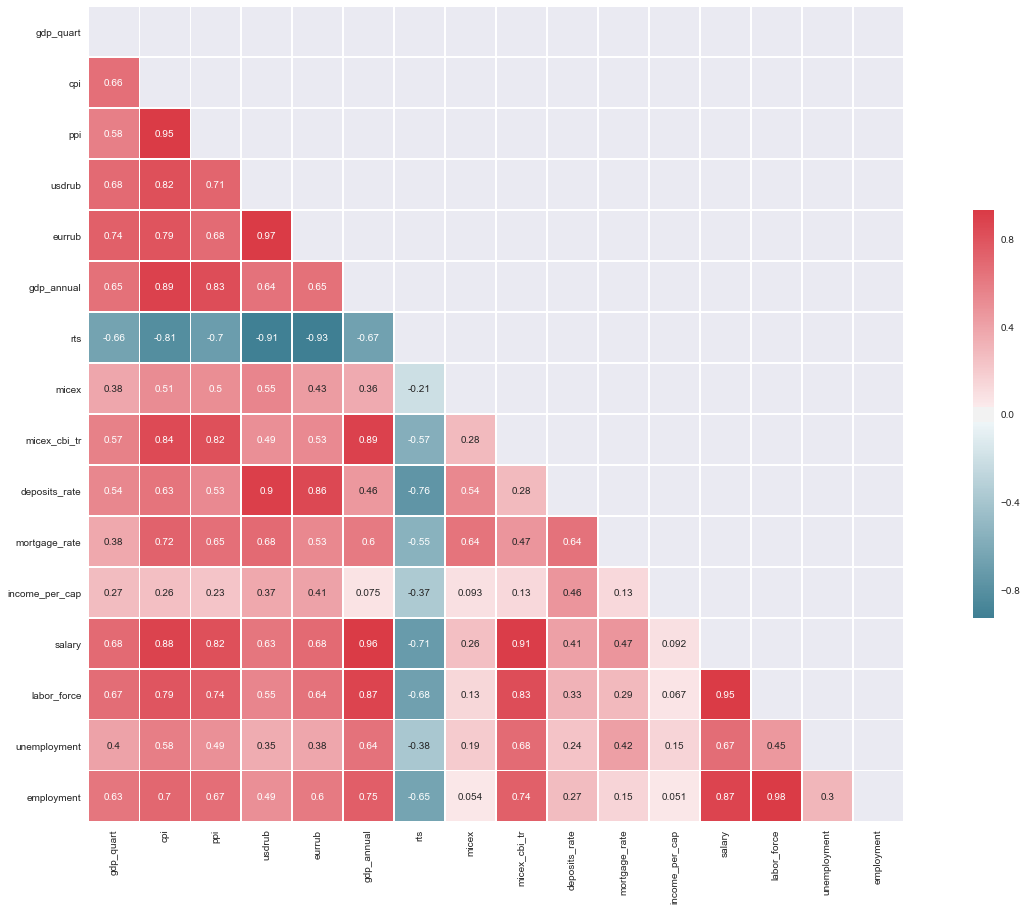

In [13]:
corr = macro_feature_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [14]:
corr2 = train_df[['gdp_quart','gdp_annual']].corr()

corr2

,gdp_quart,gdp_annual
gdp_quart,1.000000,0.649213
gdp_annual,0.649213,1.000000


In [15]:
corr3 = train_df[['gdp_quart','gdp_annual','price_doc']].corr()

corr3

,gdp_quart,gdp_annual,price_doc
gdp_quart,1.000000,0.649213,0.080978
gdp_annual,0.649213,1.000000,0.113976
price_doc,0.080978,0.113976,1.000000


not finding any significant correlation so we will look at time series

In [16]:
def trans_plot(df, x, y, fns):    
#     ulimit = np.percentile(train_df[y].values, 98.5)
#     llimit = np.percentile(train_df[y].values, 1.5)
#     train_df[y].loc[train_df[y]>ulimit] = ulimit
#     train_df[y].loc[train_df[y]<llimit] = llimit
    
#     ulimit = np.percentile(train_df[x].values, 98.5)
#     llimit = np.percentile(train_df[x].values, 1.5)
#     train_df[x].loc[train_df[x]>ulimit] = ulimit
#     train_df[x].loc[train_df[x]<llimit] = llimit
    
    f, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)
    for fn in fns:
        sns.jointplot(fn(reshape_feature(x)).values, y.values, kind="reg", dropna=True)
        plt.ylabel('{0}'.format(y), fontsize=10)
        plt.xlabel('{1}'.format(y), fontsize=10)              
    return f.tight_layout()


In [192]:
df.loc[df['build_year'].isnull()]

0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
         ...  
30441    False
30442    False
30443     True
30444    False
30445    False
30446    False
30447     True
30448     True
30449    False
30450     True
30451    False
30452    False
30453    False
30454    False
30455     True
30456    False
30457    False
30458    False
30459     True
30460    False
30461    False
30462    False
30463    False
30464    False
30465     True
30466    False
30467    False
30468     True
30469    False
30470    False
Name: build_year, Length: 30471, dtype: bool

In [ ]:
fns = [lambda x: x, np.square, np.sqrt,
       np.log, np.log1p, np.log10]

# x_='gdp_quart'
# y_='price_doc'

# trans_plot(train_df, 'gdp_quart', 'price_doc', fns)
# print [fn(reshape_feature(train_df['gdp_quart'])) for fn in fns]


In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=1)

# Maybe some original features where good, too?
selection = SelectKBest(k=3)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])
pipeline.fit(X, y)
print(pipeline)

In [39]:
np.sum(macro_df['employment'].isnull())

293

In [217]:
log_price = np.log1p(df.loc[df['price_doc'].notnull(), 'price_doc'])
price = df.loc[df['price_doc'].notnull(), 'price_doc']

g = sns.JointGrid(data=price, size=15)
g = g.plot(sns.regplot, sns.distplot)

TypeError: __init__() takes at least 3 arguments (3 given)

In [224]:
df.groupby('sub_area').mean()


,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
sub_area,,,,,,,,,,,,,,,,,,,,,
Ajeroport,8098.0,3921.0,4177.0,10478.0,4999.0,5479.0,4348.0,2123.0,2225.0,234407.0,...,17.727360,44166.0,21418.0,22748.0,0.588557,2013.740260,9151.0,4414.0,4737.0,4.442300
Akademicheskoe,10653.0,5147.0,5506.0,14297.0,7088.0,7209.0,5506.0,2645.0,2861.0,291222.0,...,6.960576,68518.0,34386.0,34132.0,0.576890,2013.856031,12074.0,5876.0,6198.0,7.757712
Alekseevskoe,7263.0,3457.0,3806.0,9514.0,4623.0,4891.0,3761.0,1806.0,1955.0,283678.0,...,16.412699,52919.0,22176.0,30743.0,0.879294,2013.946970,8186.0,3873.0,4313.0,3.563926
Altuf'evskoe,7148.0,3416.0,3732.0,9115.0,4324.0,4791.0,3559.0,1718.0,1841.0,20342.0,...,23.025154,34611.0,16976.0,17635.0,0.733276,2013.725000,8140.0,3899.0,4241.0,12.493722
Arbat,2646.0,1237.0,1409.0,3360.0,1610.0,1750.0,1379.0,658.0,721.0,150479.0,...,11.201965,17209.0,8054.0,9155.0,0.462366,2014.045455,2994.0,1425.0,1569.0,2.710974
Babushkinskoe,8429.0,3954.0,4475.0,11209.0,5113.0,6096.0,4300.0,2087.0,2213.0,10741.0,...,21.894111,52560.0,24489.0,28071.0,0.847489,2013.700637,9734.0,4542.0,5192.0,9.107000
Basmannoe,11631.0,5408.0,6223.0,15237.0,7124.0,8113.0,5706.0,2724.0,2982.0,5164.0,...,11.136090,68043.0,33807.0,34236.0,0.793833,2014.090909,13368.0,6209.0,7159.0,2.475220
Begovoe,4254.0,1994.0,2260.0,5459.0,2563.0,2896.0,2263.0,1051.0,1212.0,16025.0,...,14.778077,25933.0,12936.0,12997.0,0.803854,2013.671429,4842.0,2279.0,2563.0,1.491984
Beskudnikovskoe,8322.0,4000.0,4322.0,10271.0,4911.0,5360.0,4449.0,2168.0,2281.0,9620.0,...,22.072209,44449.0,22279.0,22170.0,1.652072,2013.778325,9308.0,4461.0,4847.0,9.305215


In [174]:
train_df[['full_sq', 'price_doc']].corr()

,full_sq,price_doc
full_sq,1.00000,0.34184
price_doc,0.34184,1.00000


In [191]:
X_train_all['full_sq']

(30506,)

In [195]:
df[['kremlin_km', 'sadovoe_km', 'price_doc']].sample(20)

,kremlin_km,sadovoe_km,price_doc
14941,15.667627,13.581502,6000000.0
2423,51.349687,49.312037,NaN
7492,4.790230,2.728497,7000000.0
11309,14.989998,12.993948,11340000.0
8284,15.141511,13.115642,7300000.0
12748,12.815695,10.270844,5200000.0
2329,5.629379,3.492935,9900000.0
9624,13.183174,11.098297,4500000.0
10996,25.735256,23.753388,6176000.0
745,22.724780,20.700074,9270000.0
